In [1]:
import numpy as np
import matplotlib. pyplot as plt

### Data Generate :

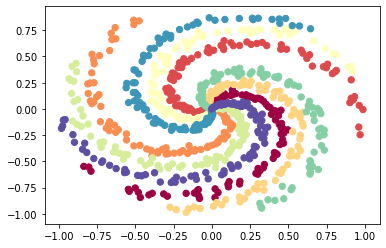

(765, 2)
(765, 9)


In [2]:
N = 85 # number of points per class
D = 2 # dimensionality
K = 9 # number of classes
inputs = np.zeros((N*K,D)) # data matrix (each row = single example)
targets = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.1 # theta
    inputs[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    targets[ix] = j

# # lets visualize the data:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets, s=40, cmap=plt.cm.Spectral)
plt.show()

one_hot = np.zeros([N*K ,K], dtype=np.int)
for i in range(len(targets)):
    one_hot[i][targets[i]] = 1 
targets = one_hot

print (inputs.shape)
print (targets.shape)

### Preparation Class :

In [3]:
class DataPreparation():
    def __init__(self, dataset, test_split=0, batch_size=0, validation_split=.0, shuffle=False):
        self.num_samples = dataset[0].shape[0]
        self.dsIndx = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(self.dsIndx)
        
        self.num_valid = int(self.num_samples * validation_split)
        self.num_test  = int(self.num_samples * test_split)
        self.num_train = self.num_samples - self.num_test - self.num_valid
            
        train_indx = self.dsIndx[0:self.num_train]
        if self.num_valid == 0:
            valid_indx = self.train_indx
            self.num_valid = self.num_samples
        else:
            valid_indx = self.dsIndx[self.num_train:self.num_train+self.num_valid]
        
        if self.num_test == 0:
            test_indx = self.train_indx
            self.num_test = self.num_samples
        else:
            test_indx = self.dsIndx[self.num_train+self.num_valid::]
            
        self.train_data = dataset[0][train_indx], dataset[1][train_indx]
        self.valid_data = dataset[0][valid_indx], dataset[1][valid_indx]
        self.test_data  = dataset[0][test_indx], dataset[1][test_indx]
        
        if batch_size == 0:
            self.batch_size = self.num_train
        else:
            self.batch_size = batch_size
        
    def train_batchs(self):
        for i in range(0, self.num_train, self.batch_size):
            yield (self.train_data[0][i:i+self.batch_size], self.train_data[1][i:i+self.batch_size]) 
    
    def info(self):
        print('Number of Samples: {}\n| # Train: {} | # Validation: {} | # Test: {}'.format
             (self.num_samples, self.num_train, self.num_valid, self.num_test))

### Model Class :

In [4]:
class NN:
    def __init__(self, layers):
        w1 = np.random.randn(layers[0], layers[1]) / np.sqrt(layers[0])
        w2 = np.random.randn(layers[1], layers[2]) / np.sqrt(layers[1])
        w3 = np.random.randn(layers[2], layers[3]) / np.sqrt(layers[2])
        b1 = np.zeros((1, layers[1]))
        b2 = np.zeros((1, layers[2]))
        b3 = np.zeros((1, layers[3]))
        self.weights= {}
        self.set_weights(w1,b1,w2,b2,w3,b3)
    
    def get_weights(self):
        w1=self.weights['w1']
        b1=self.weights['b1']
        w2=self.weights['w2']
        b2=self.weights['b2']
        w3=self.weights['w3']
        b3=self.weights['b3']
        return w1, b1, w2, b2, w3, b3
    
    def set_weights(self, w1,b1,w2,b2,w3,b3):
        self.weights['w1'] = w1
        self.weights['b1'] = b1
        self.weights['w2'] = w2
        self.weights['b2'] = b2
        self.weights['w3'] = w3
        self.weights['b3'] = b3

    
    def forward(self, x):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        hidden1 = np.maximum(0, np.dot(x, w1) + b1)
        hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
        linear = np.dot(hidden2, w3) + b3
        normalize_exp = np.exp(linear - np.max(linear))
        y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)
        return y_hat 
    
    def test(self, Data):
        x, y = Data.test_data
        y_hat = self.forward(x)
        loss = -np.sum(y * np.log(y_hat)) / Data.num_test
        accuracy = (np.argmax(y , axis=1) == np.argmax(y_hat, axis=1)).mean()
        print('Test Loss: {:.4f}, Accuracy: {:.1f}%'.format(loss, accuracy*100))
        
    def backward(self, Data, epochs, lr, reg_rate=0., verbose=1, trend_plot=False):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        train_loss = []
        train_accuracy = []
        valid_loss = []
        valid_accuracy = []
        for epoch in range(epochs):   
            iter_loss = 0.
            correct = 0
            iterations = 0    
            for (x, y) in Data.train_batchs():
                iterations +=1
                batch_size = x.shape[0]
                
                hidden1 = np.maximum(0, np.dot(x, w1) + b1)
                hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
                linear = np.dot(hidden2, w3) + b3
                normalize_exp = np.exp(linear - np.max(linear))
                y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)

                reg_loss = .5*reg_rate * np.sum(w1*w1) + .5*reg_rate * np.sum(w2*w2) + .5*reg_rate * np.sum(w3*w3)
                delta_loss = -np.sum(y * np.log(y_hat)) + reg_loss
                iter_loss += delta_loss / batch_size 

                d_loss = y_hat - y

                d_w3 = np.dot(hidden2.T, d_loss)
                d_b3 = np.sum(d_loss, axis=0, keepdims=True)

                d_hidden2 = np.dot(d_loss, w3.T)
                d_hidden2[hidden2 <=0 ] = 0

                d_w2 = np.dot(hidden1.T, d_hidden2)
                d_b2 = np.sum(d_hidden2, axis=0, keepdims=True)

                d_hidden1 = np.dot(d_hidden2, w2.T)
                d_hidden1[hidden1 <=0 ] = 0

                d_w1 = np.dot(x.T, d_hidden1)
                d_b1 = np.sum(d_hidden1, axis=0, keepdims=True)

                w1 += -lr * (d_w1 + reg_rate * w1)
                b1 += -lr * d_b1
                w2 += -lr * (d_w2 + reg_rate * w2)
                b2 += -lr * d_b2
                w3 += -lr * (d_w3 + reg_rate * w3)
                b3 += -lr * d_b3

                correct += (np.argmax(y , axis=1) == np.argmax(y_hat, axis=1)).sum()

            train_loss.append(iter_loss / iterations)
            train_accuracy.append(correct / Data.num_train)

            self.set_weights(w1,b1,w2,b2,w3,b3)

            # validation phase
            x, y = Data.valid_data
            y_hat = self.forward(x)
            loss = -np.sum(y * np.log(y_hat)) / Data.num_valid
            accuracy = (np.argmax(y, axis=1) == np.argmax(y_hat, axis=1)).mean()

            valid_loss.append(loss)
            valid_accuracy.append(accuracy)

            if epoch % verbose == 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Accurecy: {:.1f}%, Validation Loss: {:.4f}, Validation Accuracy :{:.1f}%'.format
                     (epoch, epochs, train_loss[-1], 100*train_accuracy[-1], valid_loss[-1], 100*valid_accuracy[-1]))

        print('Training Done.')

        if trend_plot:
            plt.figure(figsize=(5,5))
            plt.plot(train_loss, label = 'Trainig Loss')
            plt.plot(valid_loss, label = 'Validation Loss')
            plt.legend()
            plt.show()

            plt.figure(figsize=(5,5))
            plt.plot(train_accuracy, label = 'Trainig Accuracy')
            plt.plot(valid_accuracy, label = 'Validation Accuracy')
            plt.legend()
            plt.show()

Number of Samples: 765
| # Train: 575 | # Validation: 76 | # Test: 114
Epoch [0/5000], Loss: 2.2455, Accurecy: 15.7%, Validation Loss: 2.2277, Validation Accuracy :6.6%
Epoch [500/5000], Loss: 0.3543, Accurecy: 89.6%, Validation Loss: 0.3216, Validation Accuracy :90.8%
Epoch [1000/5000], Loss: 0.1838, Accurecy: 95.7%, Validation Loss: 0.1518, Validation Accuracy :96.1%
Epoch [1500/5000], Loss: 0.1443, Accurecy: 96.5%, Validation Loss: 0.1209, Validation Accuracy :96.1%
Epoch [2000/5000], Loss: 0.1282, Accurecy: 97.2%, Validation Loss: 0.1112, Validation Accuracy :96.1%
Epoch [2500/5000], Loss: 0.1204, Accurecy: 97.2%, Validation Loss: 0.1079, Validation Accuracy :96.1%
Epoch [3000/5000], Loss: 0.1148, Accurecy: 97.2%, Validation Loss: 0.1067, Validation Accuracy :96.1%
Epoch [3500/5000], Loss: 0.1114, Accurecy: 97.4%, Validation Loss: 0.1097, Validation Accuracy :96.1%
Epoch [4000/5000], Loss: 0.1089, Accurecy: 97.6%, Validation Loss: 0.1099, Validation Accuracy :96.1%
Epoch [4500/5000

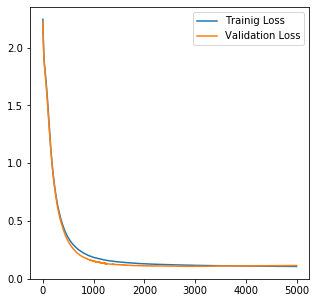

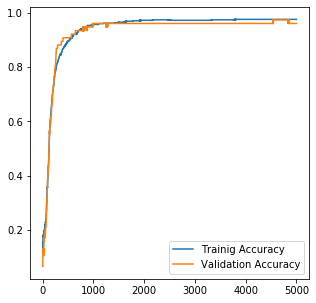

Test Loss: 0.1477, Accuracy: 94.7%


In [5]:
np.random.seed(1)
prepared_data = DataPreparation((inputs, targets),test_split=.15,batch_size=20,validation_split=.1,shuffle=True)   
prepared_data.info()

nn = NN([2, 20, 30, 9])
nn.backward(prepared_data, epochs=5000, lr= .001, reg_rate=0.001, verbose=500, trend_plot= True)
nn.test(prepared_data)